# Transit and Eclipse

### WASP-18
TESS Sector 2
- Model: Transit and Eclipse model for one instrument (TESS Sector 2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import juliet
import os
import matplotlib.gridspec as gd
import multiprocessing
import matplotlib as mpl
multiprocessing.set_start_method('fork')

mpl.rcParams.update({
    "font.family": "serif",  # Use a serif font for a more professional look
    "font.size": 12,  # Adjust font size for better readability
    "axes.labelsize": 14,  # Label size
    "axes.titlesize": 16,  # Title size
    "xtick.labelsize": 12,  # Tick label size
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 1.5,  # Thicker lines for better visibility
    "axes.linewidth": 1.2,  # Thicker axes lines
    "figure.dpi": 300,  # High-resolution figures
    "savefig.dpi": 300,  # High resolution when saving figures
    "savefig.format": "pdf",  # Save in vector format for publications
    "text.usetex": False  # Use LaTeX for better typography (optional)
})

# print('juliet version: ', juliet.__version__)

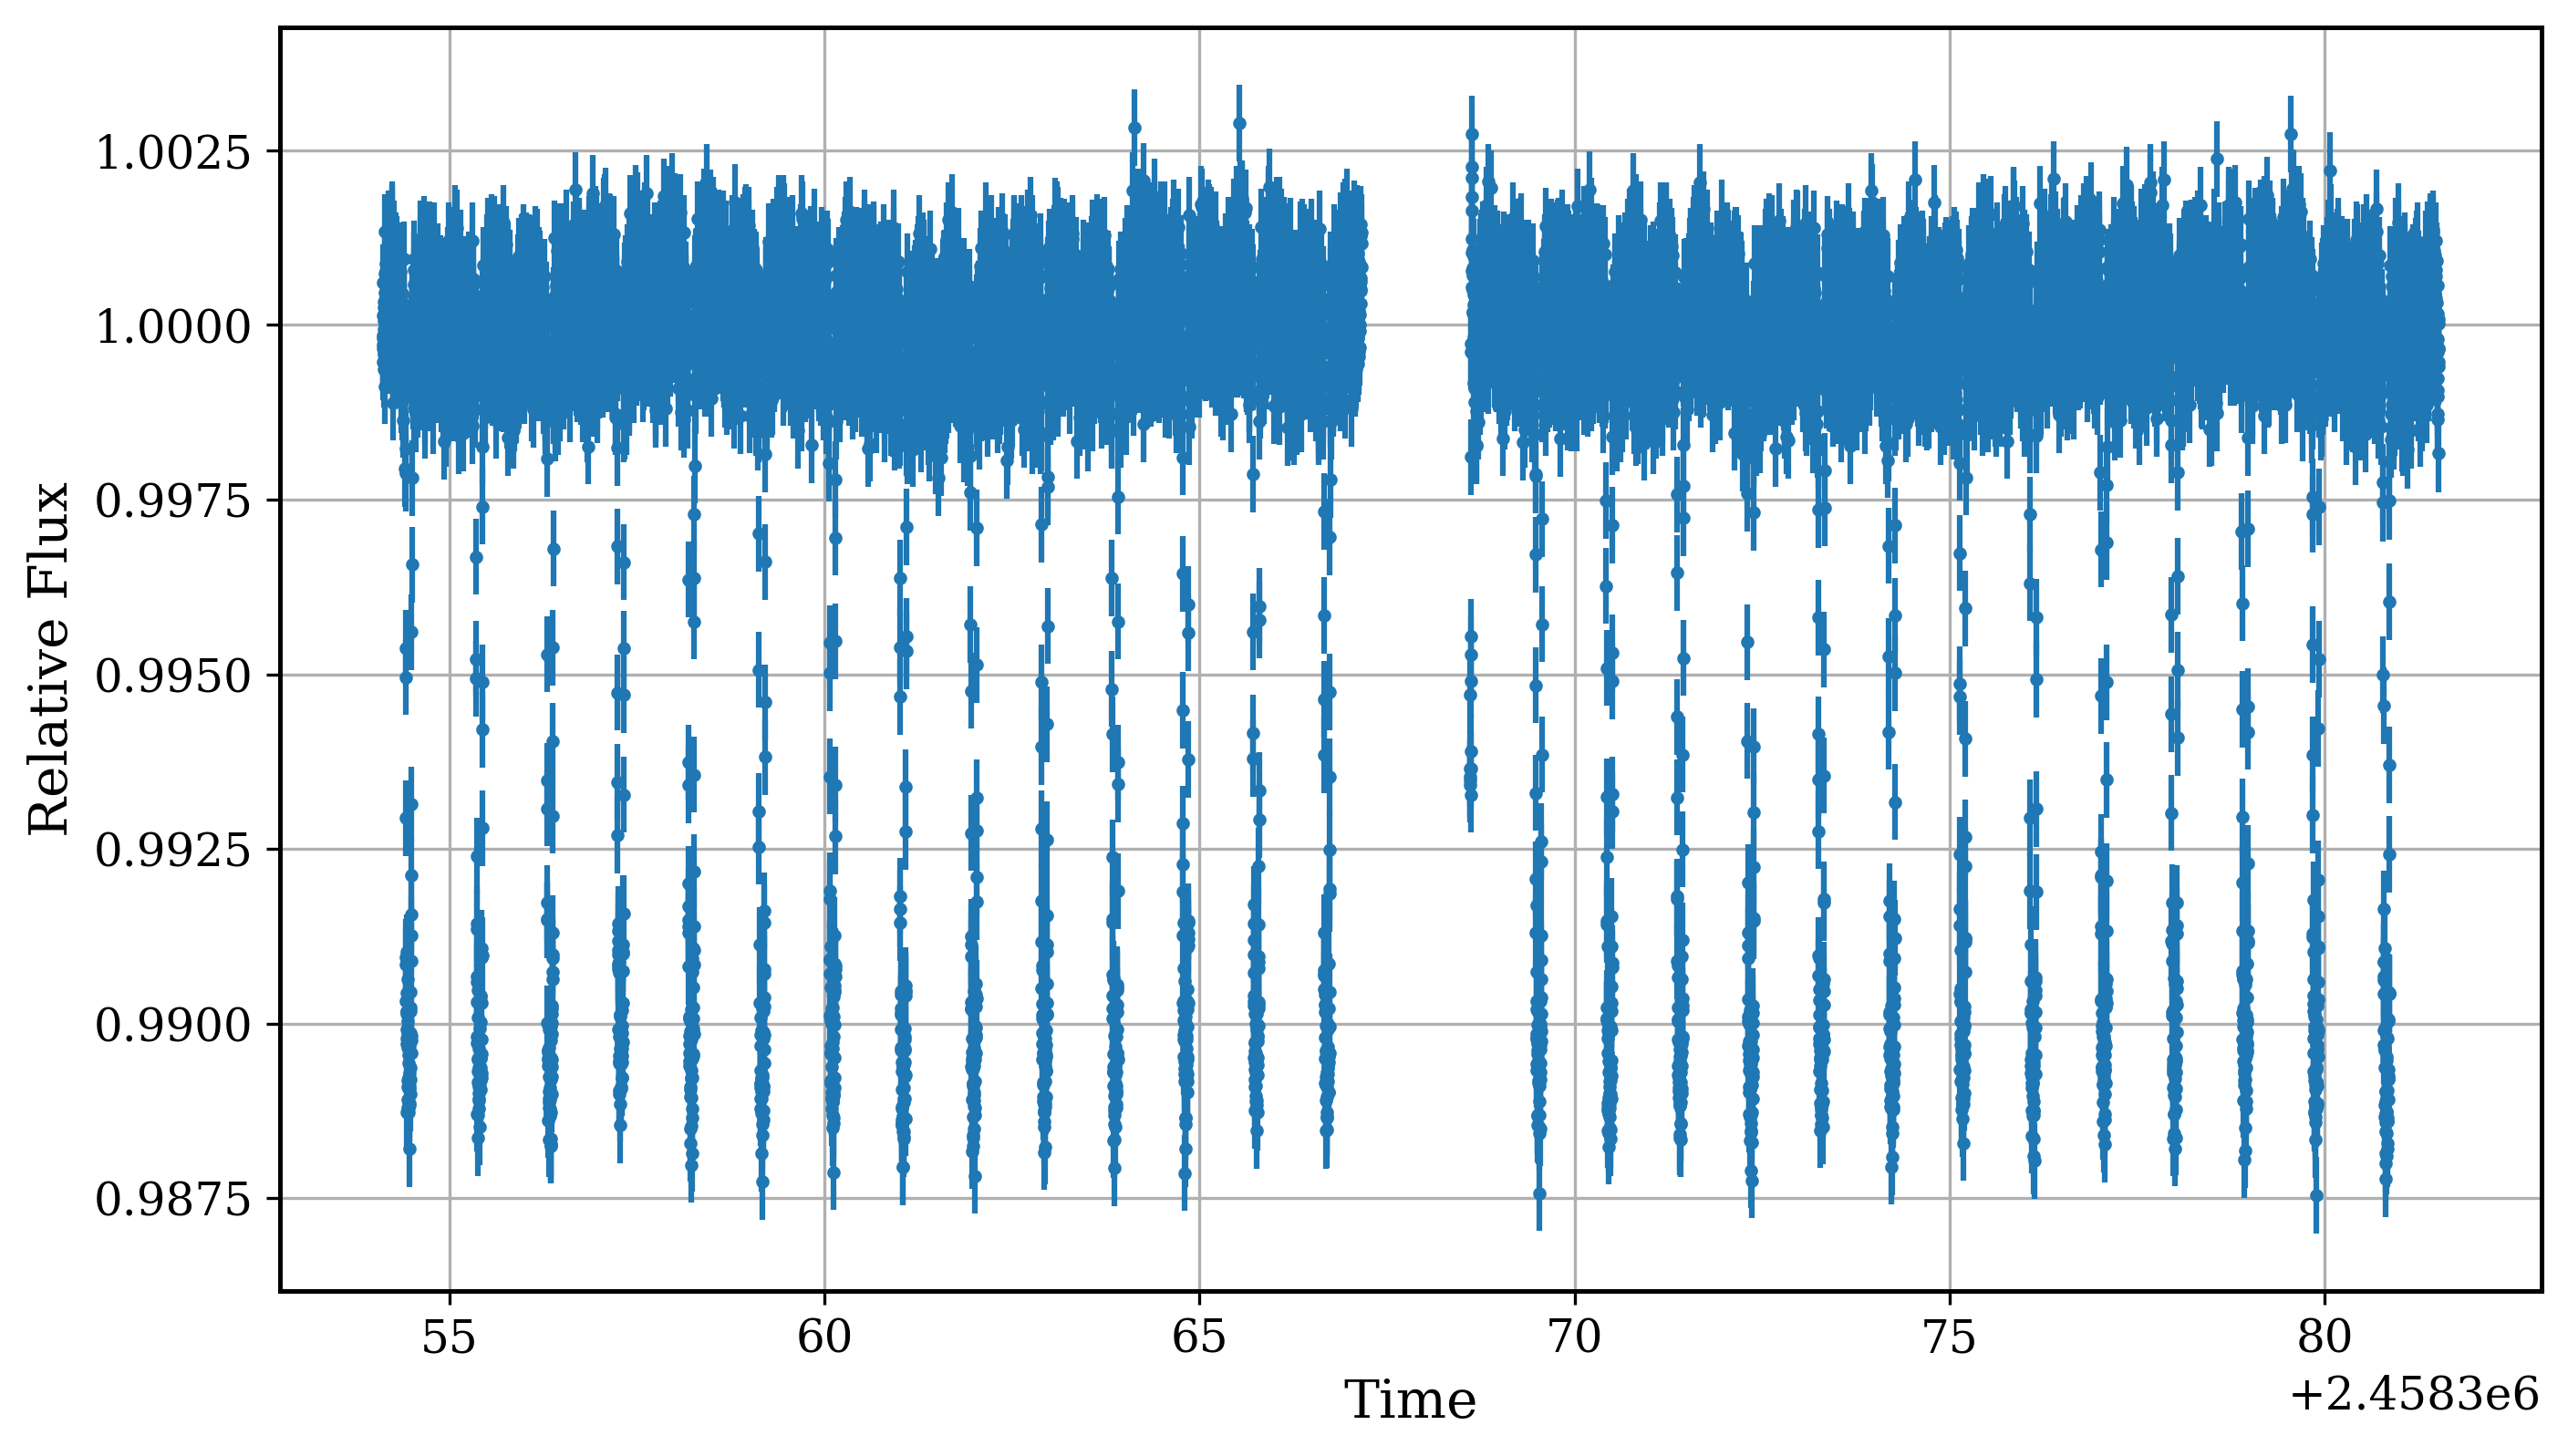

In [2]:
# tim1, fl1, fle1 = np.loadtxt(os.getcwd() + 'WASP-18_TESS2.dat',\
tim1, fl1, fle1 = np.loadtxt('WASP-18_TESS2.dat',\
    usecols=(0,1,2), unpack=True)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim1, fl1, yerr=fle1, fmt='.')
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.grid()

In [3]:
tim, fl, fle = {}, {}, {}
tim['TESS2'], fl['TESS2'], fle['TESS2'] = tim1, fl1, fle1

Since, we are interested in fitting transit and eclipse, we would,
- Include priors on eclipse depth, `fp` to fit for an eclipse model.
- Include LDCs since we also want to fit for a transit model.
- Note that `p` and `fp` both are now planetary _and_ instrumental parameters.
- Although `fp` is planetary _and_ instrumental parameter, the eclipse time is _only_ planetary parameter, i.e., we will use `t_secondary_p1`.

In [16]:
per, per_err = 0.94145223, 0.00000024    # parameters from Cortés-Zuleta et al. 2020
bjd0, bjd0_err = 2456740.80560, 0.00019

## Computing transit time for the epoch from the data
cycle = round((tim1[-1] - bjd0)/per)
tc1 = np.random.normal(bjd0, bjd0_err, 100000) + cycle*np.random.normal(per, per_err, 100000)
tc0, tc0_err = np.median(tc1), np.std(tc1)

## Time of eclipse
tc2 = tc1 + np.random.normal(per, per_err, 100000)/2
tc_ecl, tc_ecl_err = np.median(tc2), np.std(tc2)

# Priors    #original
par_P = ['P_p1', 't0_p1', 'p_p1_TESS2', 'b_p1', 'q1_TESS2', 'q2_TESS2',\
     'a_p1', 'fp_p1_TESS2', 't_secondary_p1', 'ecc_p1', 'omega_p1']
dist_P = ['normal', 'normal', 'uniform', 'uniform', 'uniform', 'uniform',\
     'loguniform', 'uniform', 'normal', 'uniform', 'uniform']
hyper_P = [[per, per_err], [tc0, 0.1], [0., 1.], [0., 1.], [0.,1.], [0.,1.],\
     [1., 10.], [0.e-6, 500.e-6], [tc_ecl, tc_ecl_err], [0., 0.1], [0., 360.0]]

##########   # debugging
# par_P = ['P_p1', 't0_p1', 'p_p1_TESS2', 'b_p1', 'q1_TESS2', 'q2_TESS2',
#          'a_p1', 'fp_p1_TESS2', 't_secondary_p1', 'sesinw_p1', 'secosw_p1']
# dist_P = ['normal', 'normal', 'uniform', 'uniform', 'uniform', 'uniform',
#           'loguniform', 'uniform', 'normal', 'uniform', 'uniform']
# hyper_P = [[per, per_err], [tc0, 0.1], [0., 1.], [0., 1.], [0., 1.], [0., 1.],
#            [1., 10.], [0.e-6, 500.e-6], [tc_ecl, tc_ecl_err], [-0.3, 0.3], [-0.3, 0.3]]
###########

par_ins = ['mdilution_TESS2', 'mflux_TESS2', 'sigma_w_TESS2']
dist_ins = ['fixed', 'normal', 'loguniform']
hyper_ins = [1., [0., 0.1], [0.1, 10000.]]

par_gp = ['GP_sigma_TESS2', 'GP_timescale_TESS2', 'GP_rho_TESS2']
dist_gp = ['loguniform', 'loguniform', 'loguniform']
hyper_gp = [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]

par_tot = par_P + par_ins + par_gp
dist_tot = dist_P + dist_ins + dist_gp
hyper_tot = hyper_P + hyper_ins + hyper_gp

priors_tot = juliet.utils.generate_priors(par_tot, dist_tot, hyper_tot)

In [17]:
# Fitting

# dataset = juliet.load(priors=priors_tot, t_lc=tim, y_lc=fl, yerr_lc=fle,\
#     GP_regressors_lc=tim, out_folder=os.getcwd() + '/Analysis/Transit-Eclipse')
# res = dataset.fit(sampler = 'dynesty', nthreads=8)

dataset = juliet.load(priors=priors_tot, t_lc=tim, y_lc=fl, yerr_lc=fle,
                      GP_regressors_lc=tim, out_folder=os.getcwd() + '/Analysis/Transit-Eclipse-ecc')
res = dataset.fit(sampler='dynesty', nthreads=8, verbose=True)

25290it [15:34, 27.05it/s, +500 | bound: 298 | nc: 1 | ncall: 869676 | eff(%):  2.967 | loglstar:   -inf < 111447.302 <    inf | logz: 111397.235 +/-  0.309 | dlogz:  0.001 >  0.509]


In [18]:
os.system("cat Analysis/Transit-Eclipse/posteriors.dat")

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 0.9414522354 	 	 0.0000002322 	 	 0.0000002368
t0_p1              	 	 2458381.7600112357 	 	 0.0000361414 	 	 0.0000331830
p_p1_TESS2         	 	 0.0981831174 	 	 0.0004429682 	 	 0.0004008085
b_p1               	 	 0.4057006231 	 	 0.0197840477 	 	 0.0221202587
q1_TESS2           	 	 0.2044895218 	 	 0.0337129471 	 	 0.0298788906
q2_TESS2           	 	 0.3431681898 	 	 0.0785394049 	 	 0.0660184484
a_p1               	 	 3.4293452624 	 	 0.0285946461 	 	 0.0269931208
fp_p1_TESS2        	 	 0.0003543454 	 	 0.0000240742 	 	 0.0000268701
t_secondary_p1     	 	 2458382.2283364395 	 	 0.0003936542 	 	 0.0003625201
mflux_TESS2        	 	 0.0002965577 	 	 0.0050853680 	 	 0.0045204413
sigma_w_TESS2      	 	 1.6018278460 	 	 8.4386753354 	 	 1.3598658638
GP_sigma_TESS2     	 	 0.0000249277 	 	 0.0000521606 	 	 0.0000122272
GP_timescale_TESS2 	 	 0.0124030931 	 	 0.0120802355 	 	 0.0083298728
GP_rho

0

_TESS2       	 	 61.8830697189 	 	 24.6917872537 	 	 25.1907426398


In [19]:
# Making model
model = res.lc.evaluate('TESS2')
gp_model = res.lc.model['TESS2']['GP']
transit_model = res.lc.model['TESS2']['deterministic']
mflx = np.median(res.posteriors['posterior_samples']['mflux_TESS2'])
sigw = np.median(res.posteriors['posterior_samples']['sigma_w_TESS2'] * 1e-6)

(2458354.1115072616, 2458381.5174589776)

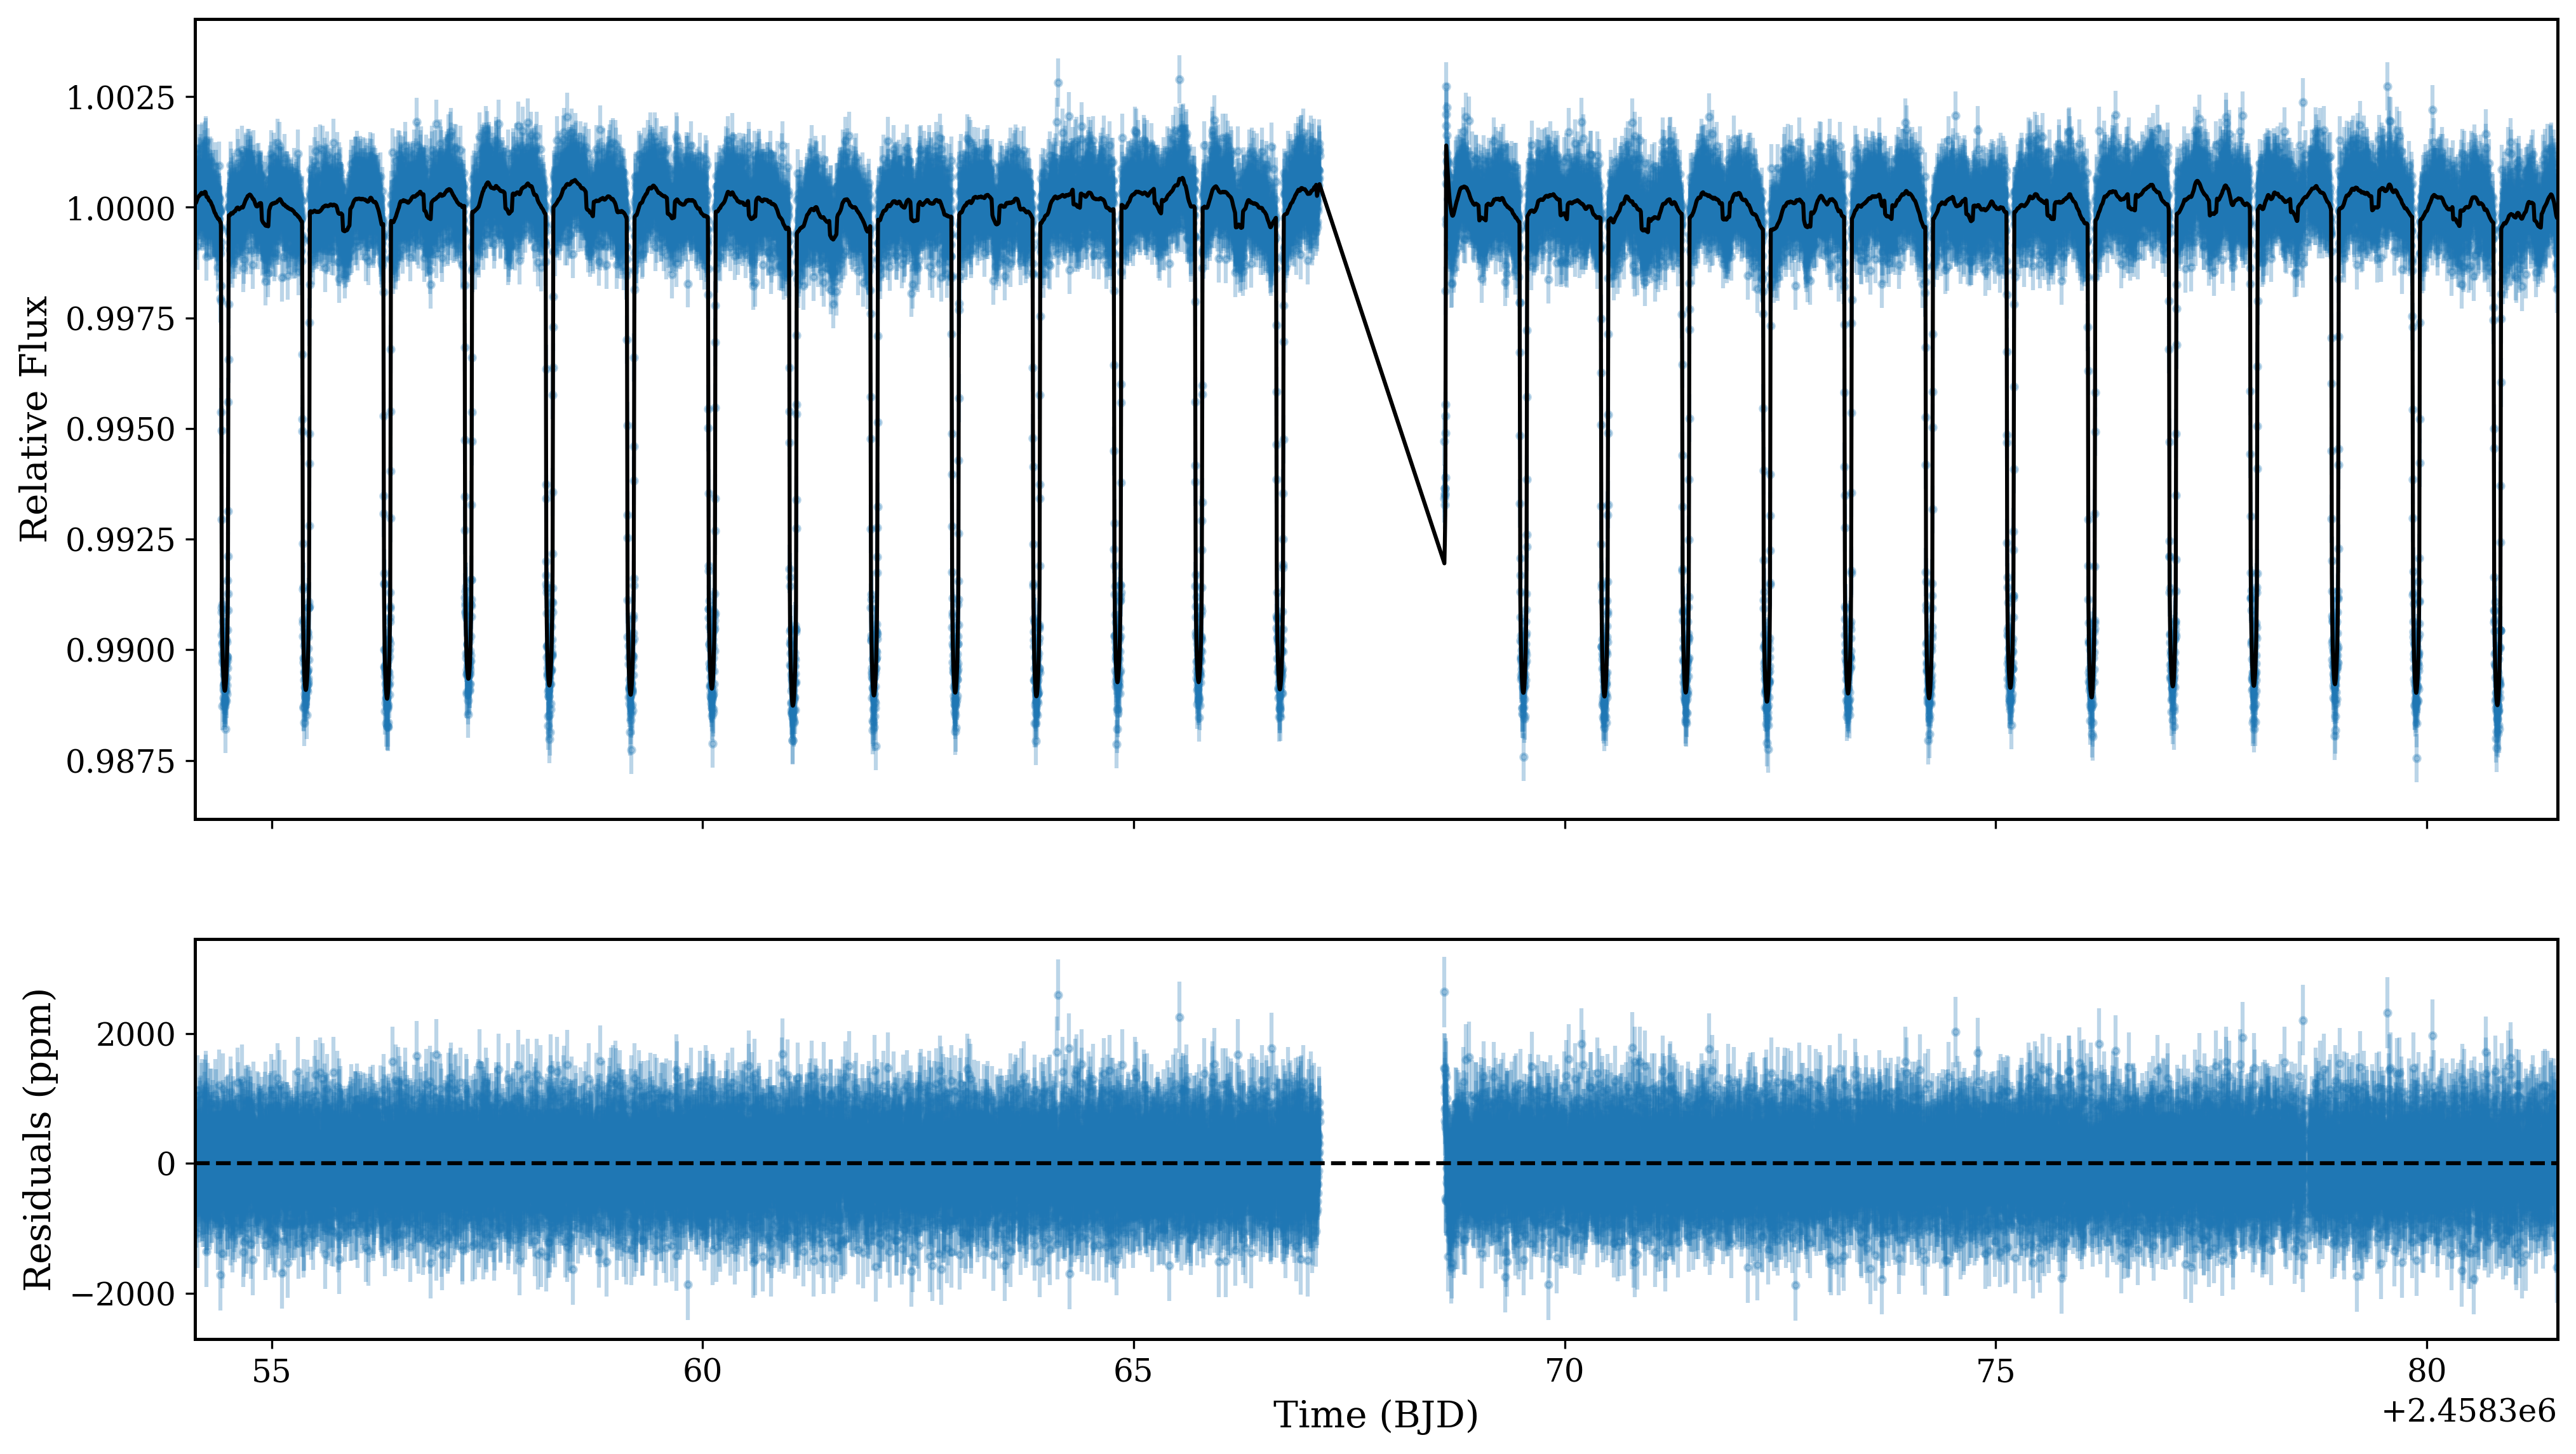

In [20]:
fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Lightcurve
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim['TESS2'], fl['TESS2'], yerr=fle['TESS2'], fmt='.', alpha=0.3)
ax1.plot(tim['TESS2'], model, c='k', zorder=100)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(np.min(tim['TESS2']), np.max(tim['TESS2']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
# fig.suptitle("WASP-18")

# Residual
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim['TESS2'], (fl['TESS2']-model)*1e6, yerr=fle['TESS2']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD)')
ax2.set_xlim(np.min(tim['TESS2']), np.max(tim['TESS2']))

### Zooming in

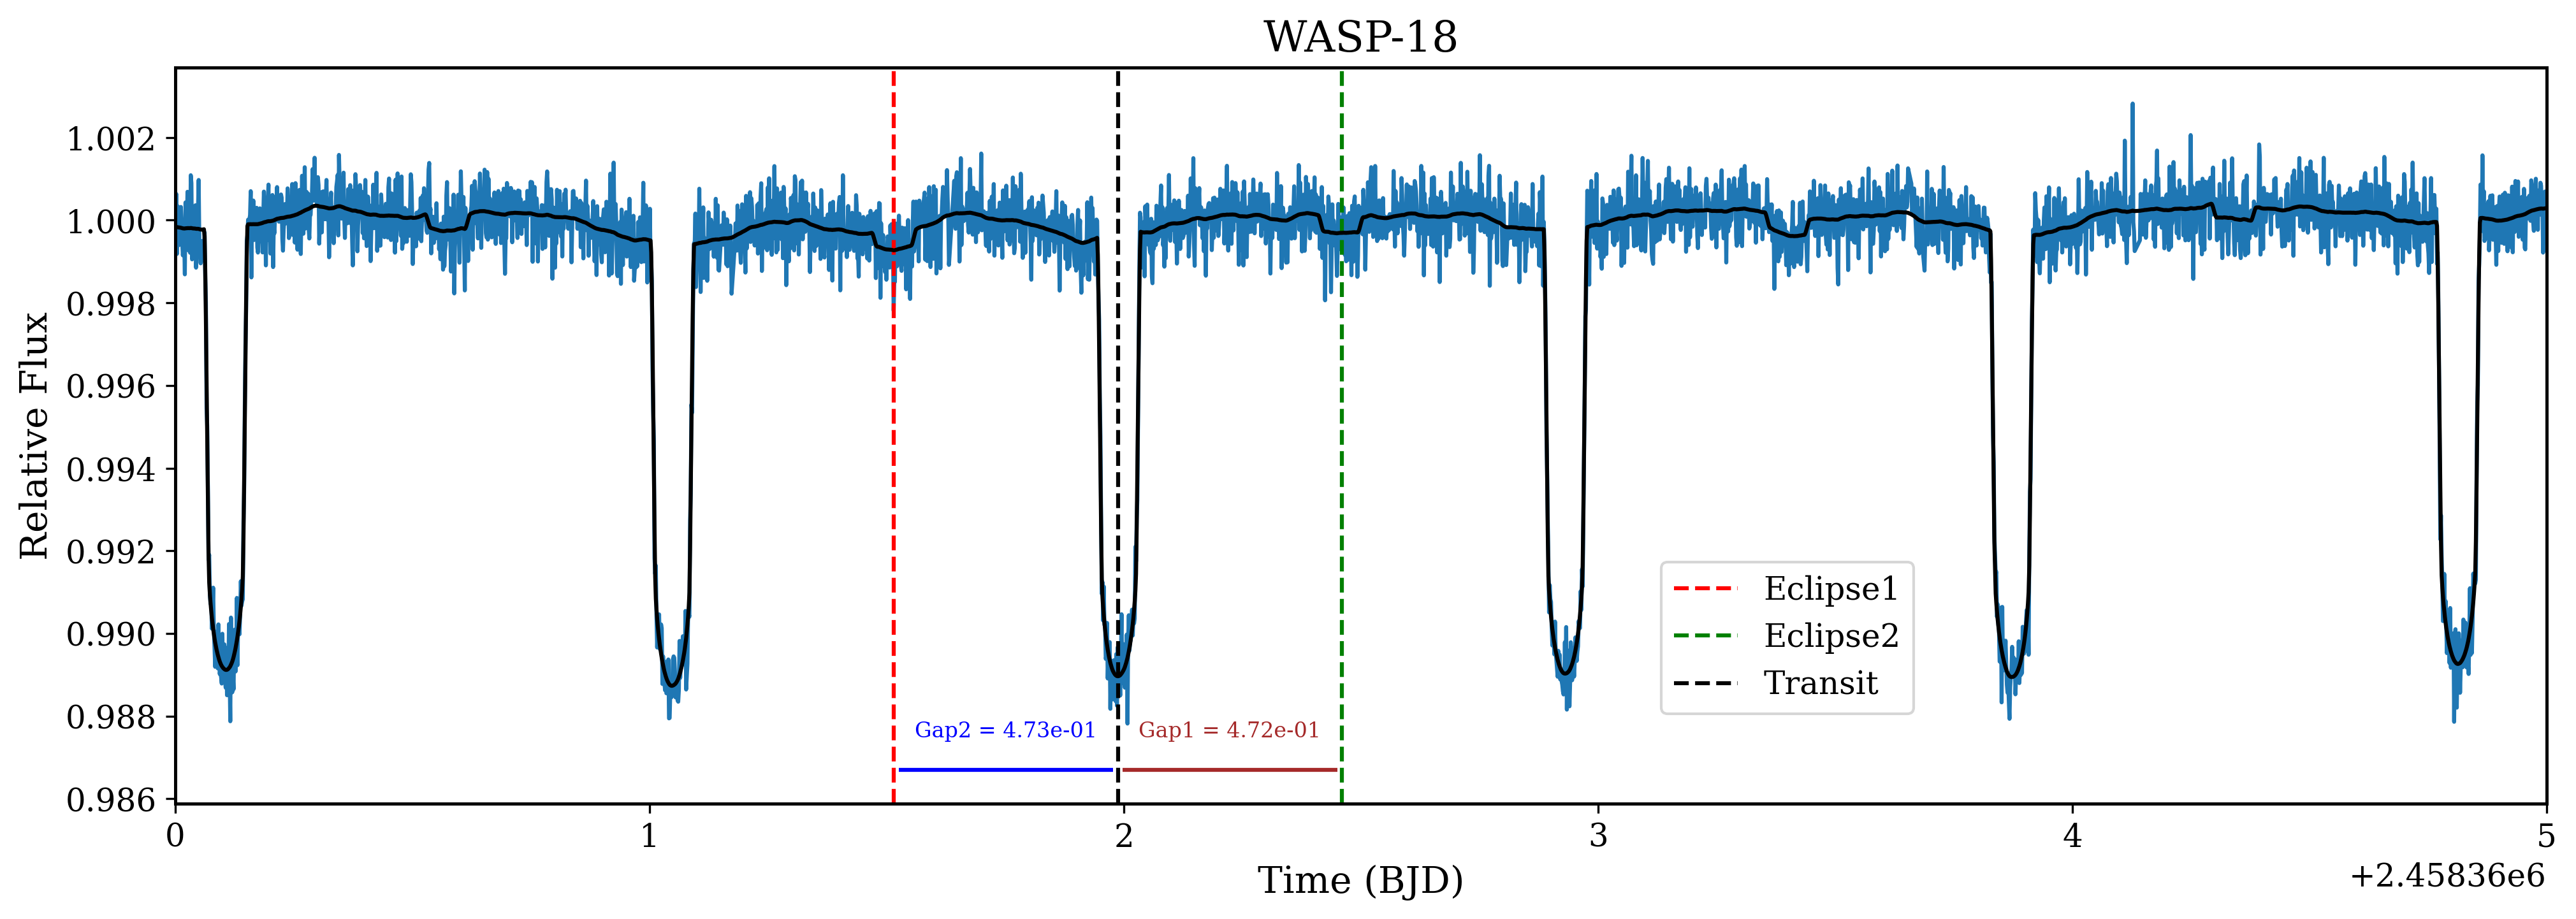

In [34]:
plt.figure(figsize=(16,5))
plt.plot(tim['TESS2'], model, c='k', zorder=100)
plt.plot(tim['TESS2'], fl['TESS2'])#, '.') #, yerr=fle['TESS2'], fmt='.', alpha=0.3)

tr1 = 1.9875 + 2.45836e6   # Transit
x1 = 1.515 + 2.45836e6  # Eclipse1
x2 = 2.46 + 2.45836e6   # Eclipse2
# xt = (x2 - x1)/2
y_gap2 = x2 - x1  # Choose a suitable y-coordinate for the horizontal line

gap1 = tr1 - x1
gap2 = x2 - tr1

# Plot vertical lines
plt.axvline(x=x1, color='red', linestyle='--', label="Eclipse1")
plt.axvline(x=x2, color='green', linestyle='--', label="Eclipse2")
plt.axvline(x=tr1, color='black', linestyle='--', label="Transit")

plt.hlines(y=0.9867, xmin=x1+0.01, xmax=tr1-0.01, color='blue', linestyle='-')#, label="Gap")
plt.text((x1 + tr1 ) / 2, 0.9865 + 0.001, f"Gap2 = {gap2:.2e}", color='blue', ha='center', fontsize=8)

plt.hlines(y=0.9867, xmin=tr1+0.01, xmax=x2-0.01, color='brown', linestyle='-')#, label="Gap")
plt.text((tr1 + x2) / 2, 0.9865 + 0.001, f"Gap1 = {gap1:.2e}", color='brown', ha='center', fontsize=8)

plt.xlim(60 + 2.4583e6, 65+ 2.4583e6)
plt.legend(loc="lower left", bbox_to_anchor=(0.62, 0.1))
plt.ylabel('Relative Flux')
plt.xlabel('Time (BJD)')
plt.title("WASP-18")
plt.show()

In [39]:
period = 0.9414522354 
e_cos_w = np.pi * (gap1/period - 0.5)
w = 158.9310344217 # from posterior
e = abs(e_cos_w / np.cos(w*np.pi/180))
print(f'e cos w = {e_cos_w}')     #  0.014261793666957933
print(f'e = {e}')                 #  0.16363573090358577

e cos w = 0.005919381140840311
e = 0.00634345104845027


Wohoooo.... We can see the eclipse signal!

### Phase-folded lightcurve to see the results more clearly:

(-0.1, 0.6)

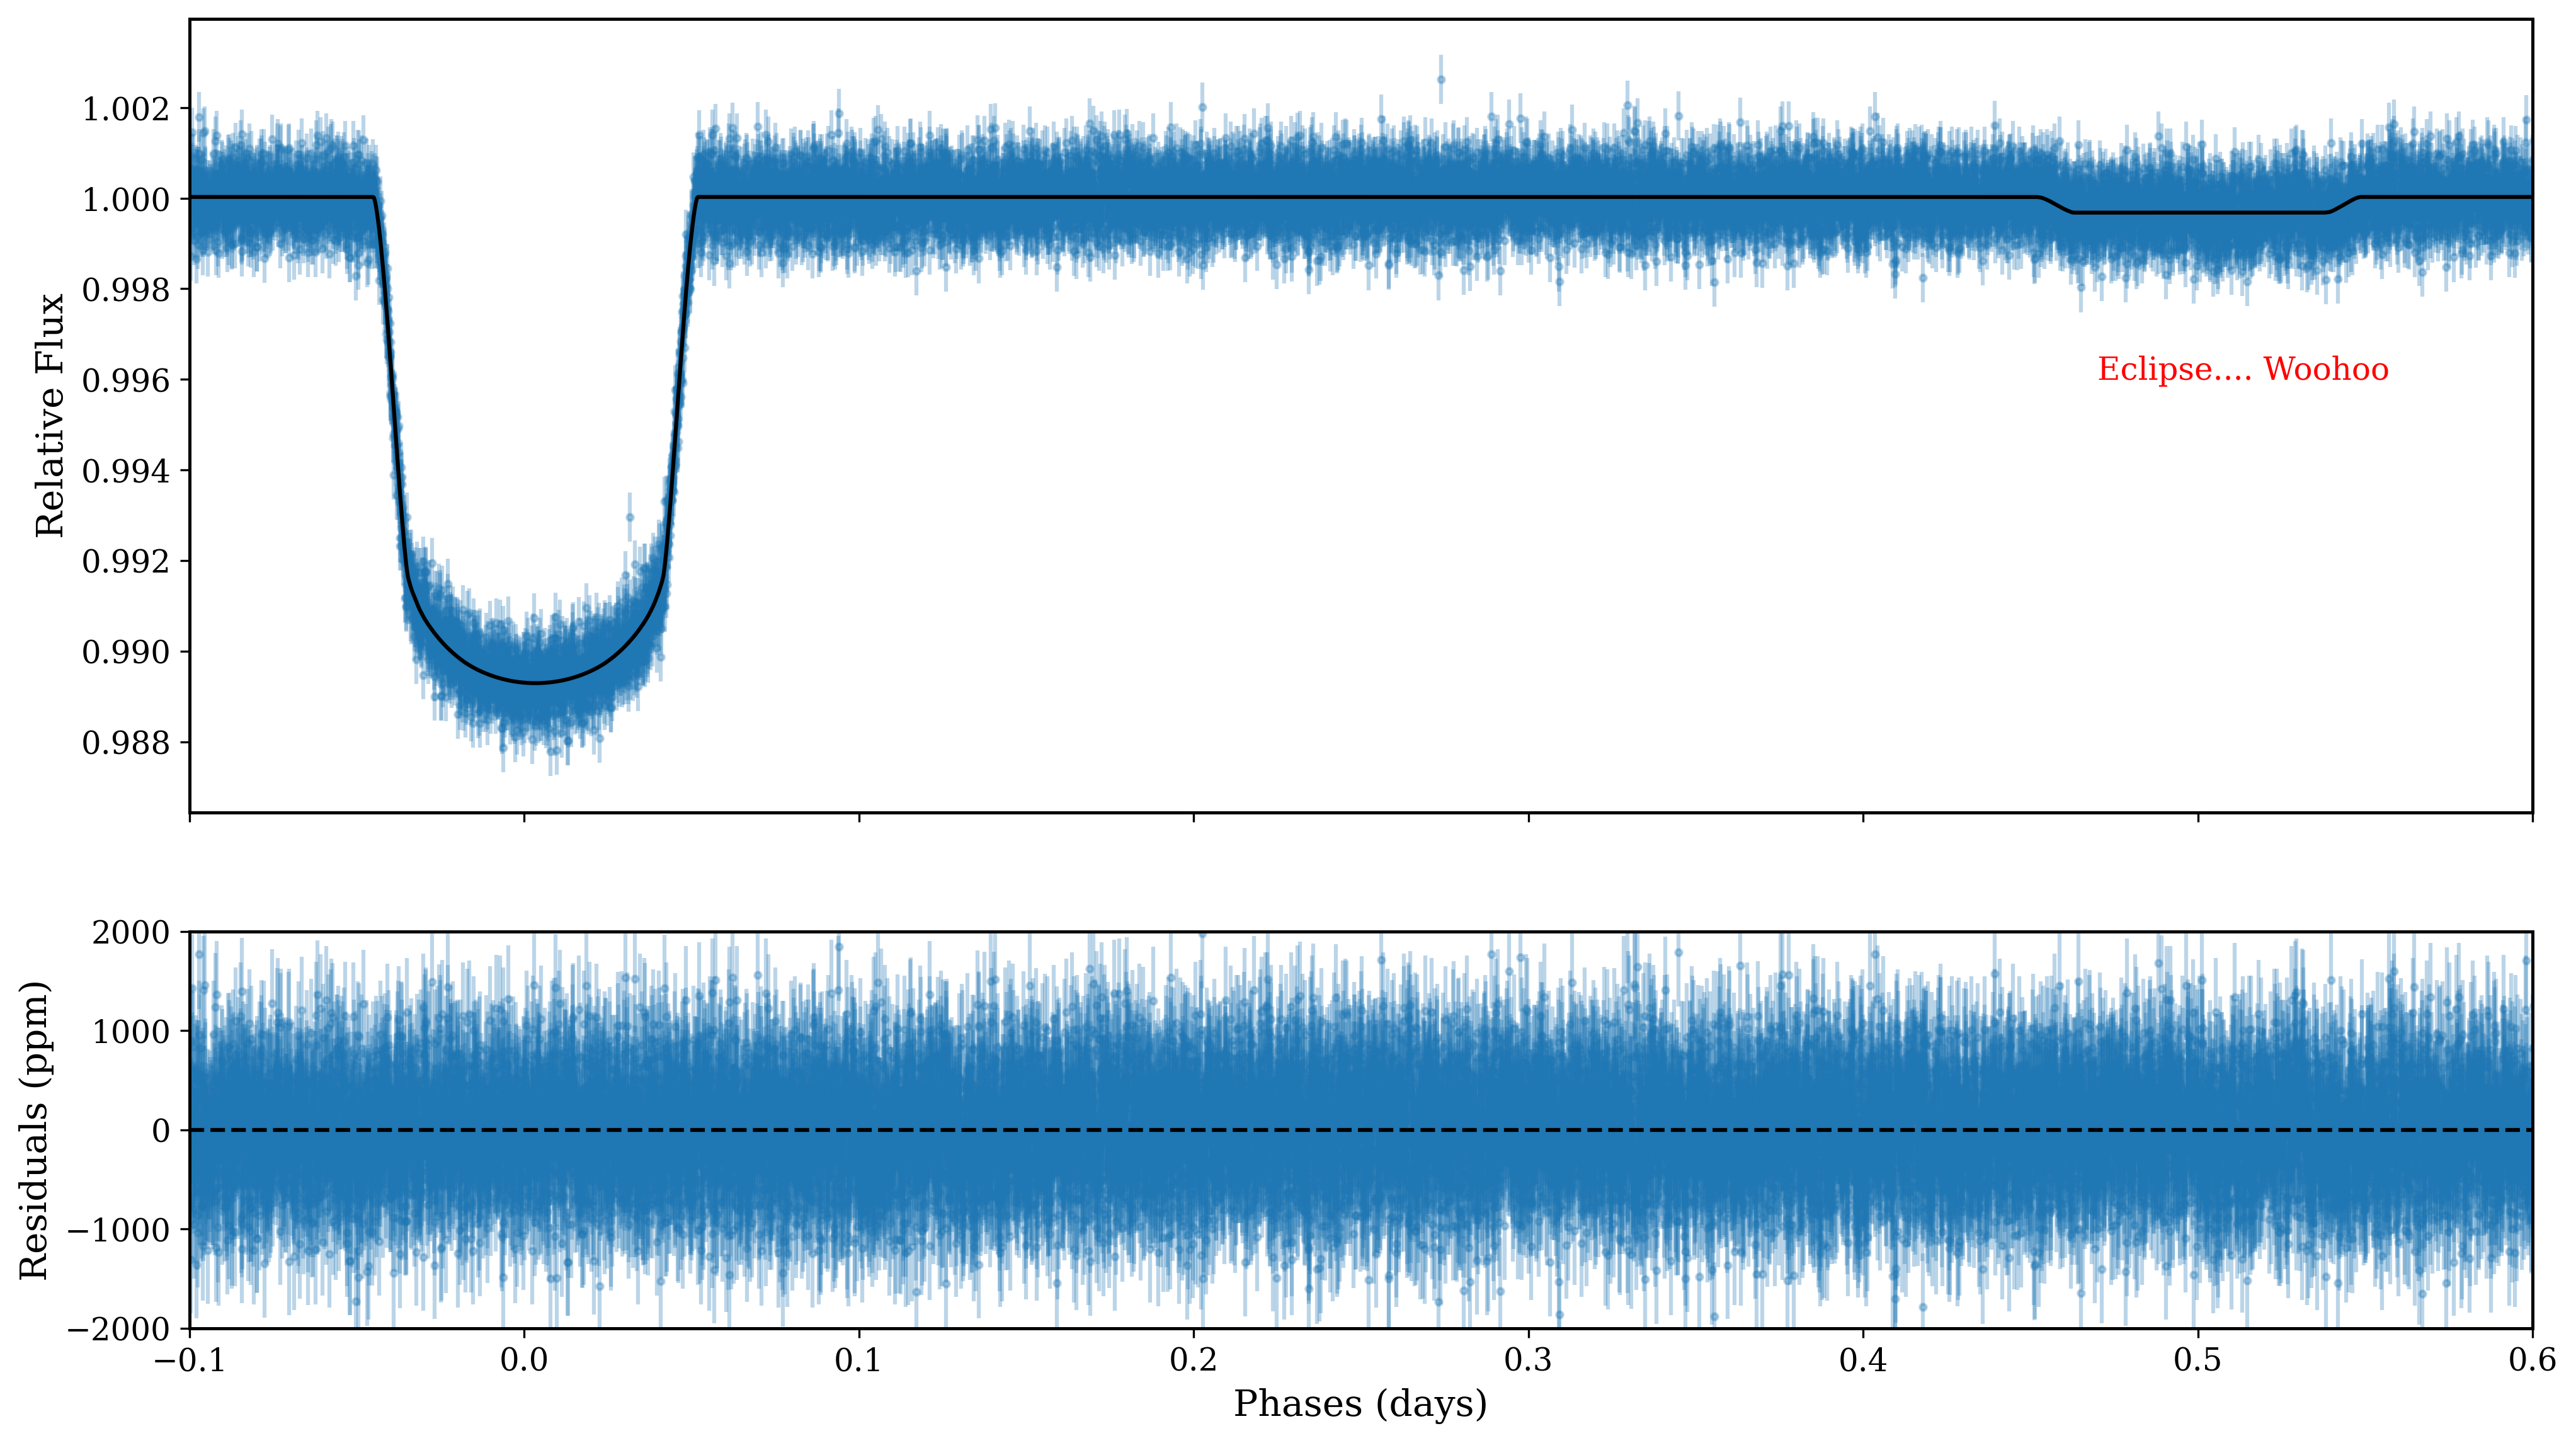

In [70]:
phs = juliet.utils.get_phases(tim['TESS2'], per, bjd0, phmin=0.8)
idx = np.argsort(phs)

fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])


ax1 = plt.subplot(gs[0])
ax1.errorbar(phs, (fl['TESS2']-gp_model) * (1 + mflx), yerr=np.sqrt(fle['TESS2']**2 + sigw**2),\
             fmt='.', alpha=0.3)
ax1.plot(phs[idx], transit_model[idx] * (1 + mflx), c='k', zorder=100)
ax1.text(0.47, 0.996, "Eclipse.... Woohoo", fontsize=12, color='red')
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(-0.1, 0.6)
#ax1.set_ylim(0.998, 1.002)
ax1.xaxis.set_major_formatter(plt.NullFormatter())


ax2 = plt.subplot(gs[1])
ax2.errorbar(phs, (fl['TESS2']-model)*1e6, yerr=np.sqrt(fle['TESS2']**2 + sigw**2) * 1e6,\
             fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Phases (days)')
ax2.set_ylim(-2000, 2000)
ax2.set_xlim(-0.1, 0.6)